In [ ]:
# required imports
import pandas as pd
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
# download the dataset
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_train.csv", "./data/X_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/y_train.csv", "./data/y_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_test.csv", "./data/X_test.csv")

X_train = pd.read_csv('./data/X_train.csv')
Y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')

# Pre-process Data + Split Training Data
We will first pre-process our training data. Here I've used the PolynomialFeatures preprocesser with the value of 1, because after trial and error as well as looking at the error curve, I've found out that degree 1 is better than degree 2 and anything above degree 3 will cause an overfitting.

In [55]:
# pre-process the training data
poly = PolynomialFeatures(degree=1)
X_poly_train = poly.fit_transform(X_train)

In [56]:
# split training data
x_train, x_test, y_train, y_test = train_test_split(X_poly_train, Y_train, test_size=0.3, random_state=0)

# Model Creation + Fitting
Here I've tried many different model types and different combination of its hyperparameters, such as GradientBoostingClassifier, RandomForestClassifier, Ridge and lastly LogisticRegression. But after trial and error and looking at both the learning and error curves, I've decided to use LogisticRegression since that it has the most decent accuracy as well as not overfitting.

In [57]:
# create model + train

# model = GradientBoostingClassifier(
#     max_features='auto',
#     n_estimators=8, 
#     random_state=42,
#     max_depth=5, 
#     min_samples_leaf=10, 
#     learning_rate = 0.1
# )
# test accuracy:
# 0.6117546451061183
# train accuracy:
# 0.6220574760516452
# But it will overfit based on the learning curve

# model = RandomForestClassifier(
#     max_features='auto',
#     n_estimators=10, 
#     random_state=42, 
#     max_depth=5, 
#     min_samples_leaf=100
# ) 
# test accuracy:
# 0.6106273808598305
# train accuracy:
# 0.6189087880049979
# But it will overfit based on the learning curve

sc = StandardScaler()
lr = LogisticRegression(max_iter=10000,random_state=11,C=1)
model = Pipeline(steps=(['scaler',sc], ['classifier',lr]))

model.fit(x_train, y_train.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ['classifier',
                 LogisticRegression(C=1, max_iter=10000, random_state=11)]])

In [58]:
# predict testing data
y_pred = model.predict(x_test)

# Test score
score_gb = model.score(x_test, y_test)
print('test accuracy:')
print(score_gb)
print('train accuracy:')
print(model.score(x_train, y_train))

test accuracy:
0.6093835030708233
train accuracy:
0.6082299042065806


# Drawing Error and Learning Curves
After fitting the model and testing it on the training and testing data, I will then try and draw both the error and learning curve to find out if the model is overfitting or not. 

current degree:  1
current mse_train:  0.3917700957934194
current mse_test:  0.3906164969291767
current degree:  2
current mse_train:  0.38369012911286965
current mse_test:  0.38575759931586723
current degree:  3
current mse_train:  0.3807246980424823
current mse_test:  0.38622405348674493
current degree:  4
current mse_train:  0.37807580174927113
current mse_test:  0.38902277851201117
current degree:  5
current mse_train:  0.3750104123281966
current mse_test:  0.389333747959263


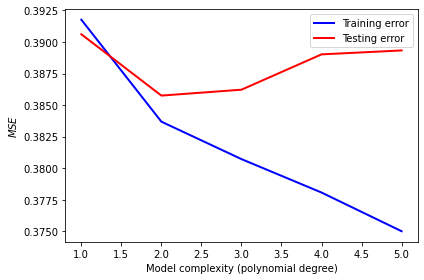

In [26]:
# draw error curve
mse_train = []
mse_test = []

max_degree = 6

for d in range(1, max_degree):
    print('current degree: ', d)
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(x_train)
    X_test_poly = poly.transform(x_test)
    
    sc = StandardScaler()
    lr = LogisticRegression(max_iter=10000,random_state=11,C=1)
    model = Pipeline(steps=(['scaler',sc], ['classifier',lr]))

    model.fit(X_train_poly, y_train.values.ravel())
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))
    print('current mse_train: ', mse_train[d-1])
    print('current mse_test: ', mse_test[d-1])
    

plt.plot(range(1, max_degree), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_degree), mse_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

Here based on the error curve we can see that both the training and testing error started off on a high value and it will then continue to decrease in value, but after the polynomial degree is bigger than 2, it will have a large gap between the 2 error, hence we can conclude that using a degree of higher than 2 will cause an overfitting on the model.

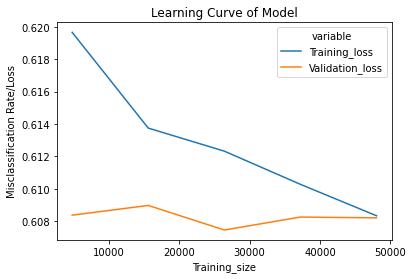

In [59]:
# draw learning curve
def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

train_size,train_scores,test_scores = learning_curve(
    estimator=model,
    X=x_train,
    y=y_train.values.ravel(),
    scoring=mse
)

train_scores = 1-np.mean(train_scores,axis=1)
test_scores = 1-np.mean(test_scores,axis=1)
lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")

sns.lineplot(data=lc,x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of Model")
plt.ylabel("Misclassification Rate/Loss");

Here we can see that the training loss started of from a high value and soon decrease, meanwhile the validation loss will start at a lower value but towards the end it will flatten, which is the behaviour that we are looking for when searching for a good fit. Moreover, the value between the training and validation loss is not that much different, which is also another behaviour that we are looking for when searching for a good fit.

# Feature Selection
Next I will be using the correlation between each attribute to find out which attributes have the highest correlation with each other so that we can focus on those features to get a higher accuracy on our prediction. Here I will be using a heatmap to visualize it better.

<AxesSubplot:>

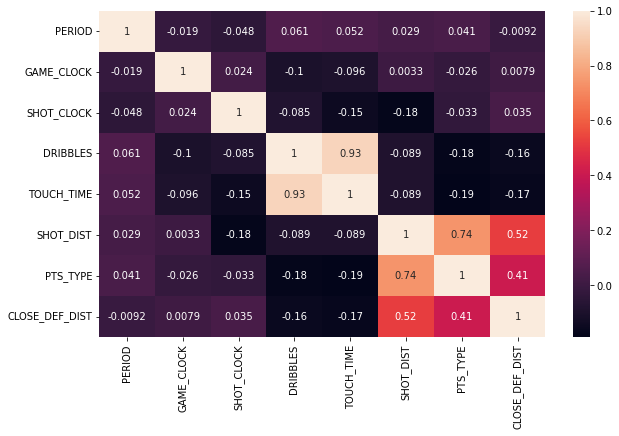

In [28]:
# find features with high correlation
cor = X_test.corr()

plt.figure(figsize = (10, 6))
sns.heatmap(cor, annot = True)

In [33]:
# select the 3 features that we want to focus on
X_test_selected = X_test.drop(columns = ['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME'], axis = 1)
X_train_selected = X_train.drop(columns = ['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME'], axis = 1)

test accuracy:
0.6021534634222188
train accuracy:
0.6044814660558101


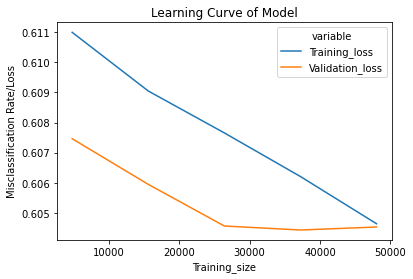

In [34]:
# pre-process the training data
poly = PolynomialFeatures(degree=1)
X_poly_train_selected = poly.fit_transform(X_train_selected)

# split training data
x_train_selected, x_test_selected, y_train_selected, y_test_selected = train_test_split(X_poly_train_selected, Y_train, test_size=0.3, random_state=0)

model.fit(x_train_selected, y_train_selected.values.ravel())

# predict testing data
y_pred_selected = model.predict(x_test_selected)

# Test score
score_gb = model.score(x_test_selected, y_test_selected)
print('test accuracy:')
print(score_gb)
print('train accuracy:')
print(model.score(x_train_selected, y_train_selected))

train_size,train_scores,test_scores = learning_curve(
    estimator=model,
    X=x_train_selected,
    y=y_train_selected.values.ravel(),
    scoring=mse
)

train_scores = 1-np.mean(train_scores,axis=1)
test_scores = 1-np.mean(test_scores,axis=1)
lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")

sns.lineplot(data=lc,x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of Model")
plt.ylabel("Misclassification Rate/Loss");

Based on the learning curve above we can conclude that after doing feature selection we will be able to obtain a more desirable learning curve because here we can clearly see that the validation loss will start at a higher value which will then flatten towards the end, which is exactly the behaviour of a good fit model.

# Predicting Future Data
Lastly, we are going to predict the y value (FGM) based on the model that we have created and the data that we have pre-processed and done feature selection with.

In [35]:
# predict real testing data
X_poly_test_selected = poly.fit_transform(X_test_selected)
y_real_pred = model.predict(X_poly_test_selected)

In [36]:
# save and reformat prediction data
pd.DataFrame(y_real_pred, columns=['FGM']).to_csv("./Lab05_108062182_y_pred.csv")